In [1]:
import numpy as np
import pyhdf
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
from datetime import datetime, timezone
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt

In [2]:
## ===============================================
def read_2b_cldclass_lidar(cs_file,latbin=None):
## ===============================================
  f_2b_cldclass_lidar=SD(cs_file, SDC.READ)
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerBase')
  cs_clb =sds_obj.get()
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerTop')
  cs_clt =sds_obj.get()

  ## geolocation fields
  sdc_2bcldclass_lidar=HDF(cs_file, SDC.READ)
  vs_2bcldclass_lidar=sdc_2bcldclass_lidar.vstart()
  cs_QC = np.squeeze(vs_2bcldclass_lidar.attach('Data_quality')[:])
  Latitude = np.squeeze(vs_2bcldclass_lidar.attach('Latitude')[:])
  Longitude = np.squeeze(vs_2bcldclass_lidar.attach('Longitude')[:])

  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  cs_clb = cs_clb[ilat,:]
  cs_clt = cs_clt[ilat,:]
  cs_QC = cs_QC[ilat]
  Latitude = Latitude[ilat]
  Longitude = Longitude[ilat]

  return(cs_clb,cs_clt,cs_QC,Latitude,Longitude)

## ===============================================
def read_cs_ecmwf(aux_file,latbin=None):
## ===============================================
  f_ecmwf=SD(aux_file, SDC.READ)
  sds_obj=f_ecmwf.select('Pressure')
  Pressure =sds_obj.get()
  sds_obj=f_ecmwf.select('Temperature')
  Temperature =sds_obj.get()
  sds_obj=f_ecmwf.select('Specific_humidity')
  Specific_humidity =sds_obj.get()
  #sds_obj=f_ecmwf.select('U_velocity')
  #U_velocity =sds_obj.get()
  #sds_obj=f_ecmwf.select('V_velocity')
  #V_velocity =sds_obj.get()

  ## geolocation fields
  sdc_ecmwf=HDF(aux_file, SDC.READ)
  vs_ecmwf=sdc_ecmwf.vstart()
  EC_height = np.squeeze(vs_ecmwf.attach('EC_height')[:])
  Profile_time = np.squeeze(vs_ecmwf.attach('Profile_time')[:])
  UTC_start = np.squeeze(vs_ecmwf.attach('UTC_start')[:])
  #TAI_start = np.squeeze(vs_ecmwf.attach('TAI_start')[:])
  Latitude = np.squeeze(vs_ecmwf.attach('Latitude')[:])
  Longitude = np.squeeze(vs_ecmwf.attach('Longitude')[:])
  DEM_elevation = np.squeeze(vs_ecmwf.attach('DEM_elevation')[:])
  Skin_temperature = np.squeeze(vs_ecmwf.attach('Skin_temperature')[:])
  Surface_pressure = np.squeeze(vs_ecmwf.attach('Surface_pressure')[:])
  Temperature_2m = np.squeeze(vs_ecmwf.attach('Temperature_2m')[:])
  #Sea_surface_temperature = np.squeeze(vs_ecmwf.attach('Sea_surface_temperature')[:])
  U10_velocity = np.squeeze(vs_ecmwf.attach('U10_velocity')[:])
  V10_velocity = np.squeeze(vs_ecmwf.attach('V10_velocity')[:])


  UTC_Time = UTC_start + Profile_time
  UTC_Time = UTC_Time/60./60.
  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  Pressure = Pressure[ilat,:]
  Temperature = Temperature[ilat,:]
  Specific_humidity = Specific_humidity[ilat,:]
  DEM_elevation = DEM_elevation[ilat]
  Skin_temperature = Skin_temperature[ilat]
  Temperature_2m = Temperature_2m[ilat]
  U10_velocity = U10_velocity[ilat]
  V10_velocity = V10_velocity[ilat]
  UTC_Time = UTC_Time[ilat]


  return(Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,U10_velocity,V10_velocity,UTC_Time)

In [3]:
#=================================
#    MAIN
#=================================
yy = '2018'
ddn = '285'; orbit = '66348'
latb = [-50.,50.] #//only crop images between 50S and 50N


cloudsatpath = '/explore/nobackup/people/jgong/cloudsat/'
#cloudsatpath = '/discover/nobackup/jgong/cloudsat/'
cs_file = glob.glob(cloudsatpath+'2B-CLDCLASS-LIDAR/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*2B-CLDCLASS-LIDAR*'+'P1_R05*.hdf')
aux_file = glob.glob(cloudsatpath+'ECMWF-AUX/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*ECMWF-AUX*'+'P1_R05*.hdf')

print(cs_file[0],aux_file[0])

##========== read ecmwf-aux ================================
[Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,\
        U10_velocity,V10_velocity,UTC_Time] = read_cs_ecmwf(aux_file[0],latbin=latb)

##========== read 2b-cldclass-lidar ================================
[cs_clb,cs_clt,cs_QC,Latitude,Longitude] = read_2b_cldclass_lidar(cs_file[0],latbin=latb)

print(cs_clb[10003,:])
print(cs_clt[10003,:])
print(UTC_Time[10003],Latitude[10003],Longitude[10003])

for i in np.arange(10):
  tmp=np.squeeze(cs_clt[:,i])
  ind=np.argwhere(tmp>0)
  print(len(ind),len(tmp))

#---- implementing the 40-level cloud mask processing code from ----
#---- https://colab.research.google.com/drive/1cIsSLS5ht8PXQ8bAbJpboAIxrnanwupu -----

/explore/nobackup/people/jgong/cloudsat/2B-CLDCLASS-LIDAR/2018/285/2018285102109_66348_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf /explore/nobackup/people/jgong/cloudsat/ECMWF-AUX/2018/285/2018285102109_66348_CS_ECMWF-AUX_GRANULE_P1_R05_E08_F03.hdf
[  1.7499988 -99.        -99.        -99.        -99.        -99.
 -99.        -99.        -99.        -99.       ]
[  2.2299986 -99.        -99.        -99.        -99.        -99.
 -99.        -99.        -99.        -99.       ]
11.158374362521702 -3.6475839614868164 39.9209098815918
5499 20737
1880 20737
414 20737
52 20737
2 20737
0 20737
0 20737
0 20737
0 20737
0 20737


In [4]:
N = len(cs_clb)

cs_clb_2 = np.floor(2 * cs_clb).astype(int)
cs_clt_2 = np.floor(2 * cs_clt).astype(int)

newRescaled = np.zeros((N, 40)).astype(int)
for i in range(N):
    for j in range(10):
        if cs_clb[i, j] == -99:
            break
        newRescaled[i, cs_clb_2[i, j]:cs_clt_2[i, j]+1] = 1

print(cs_clb[6000, :])
print(cs_clt[6000, :])
newRescaled[6000, :]

[  0.31       8.950005 -99.       -99.       -99.       -99.
 -99.       -99.       -99.       -99.      ]
[  7.210019  11.770024 -99.       -99.       -99.       -99.
 -99.       -99.       -99.       -99.      ]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
Longitude

array([-128.50894165, -128.51098633, -128.51301575, ..., -153.13804626,
       -153.14009094, -153.14212036])

In [20]:
# Temperature.shape
# Temperature_interp = np.zeros((N, 40))

# for i in range(N):
#     f = interpolate.interp1d(np.linspace(0,1,125), Temperature[i], kind='linear')
#     Temperature_interp[i] = f(np.linspace(0, 1, 40))

z_grid=np.arange(40)*0.5
N = Temperature.shape[0]
Temperature_grid = np.zeros((N, len(z_grid)))
for i in range(N):
    Temperature_tmp=np.squeeze(Temperature[i,:])
    ivalid=np.squeeze(np.where(Temperature_tmp > 0))

    Temperature_grid[i, :]=np.interp(z_grid,np.flip(EC_height[ivalid]/1000.),np.flip(Temperature_tmp[ivalid]))

Temperature_grid = np.flip(Temperature_grid, axis=1)

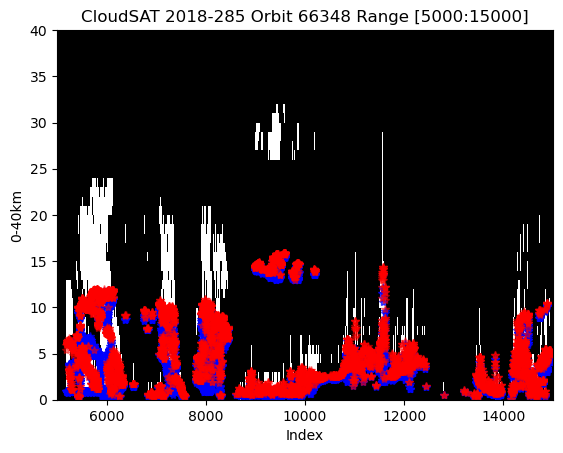

In [14]:
index = np.arange(5000, 15000, 1)
plt.imshow(newRescaled[index].T, cmap='gray', interpolation='nearest', aspect='auto', extent=[5000, 15000, 40, 0])
plt.gca().invert_yaxis()
plt.title('CloudSAT 2018-285 Orbit 66348 Range [5000:15000]')
plt.xlabel('Index')
plt.ylabel('0-40km')
plt.ylim(0,40)
plt.plot(index, cs_clb[index], 'b*', alpha=0.7)
plt.plot(index,cs_clt[index], 'r*', alpha=0.5)
plt.show()

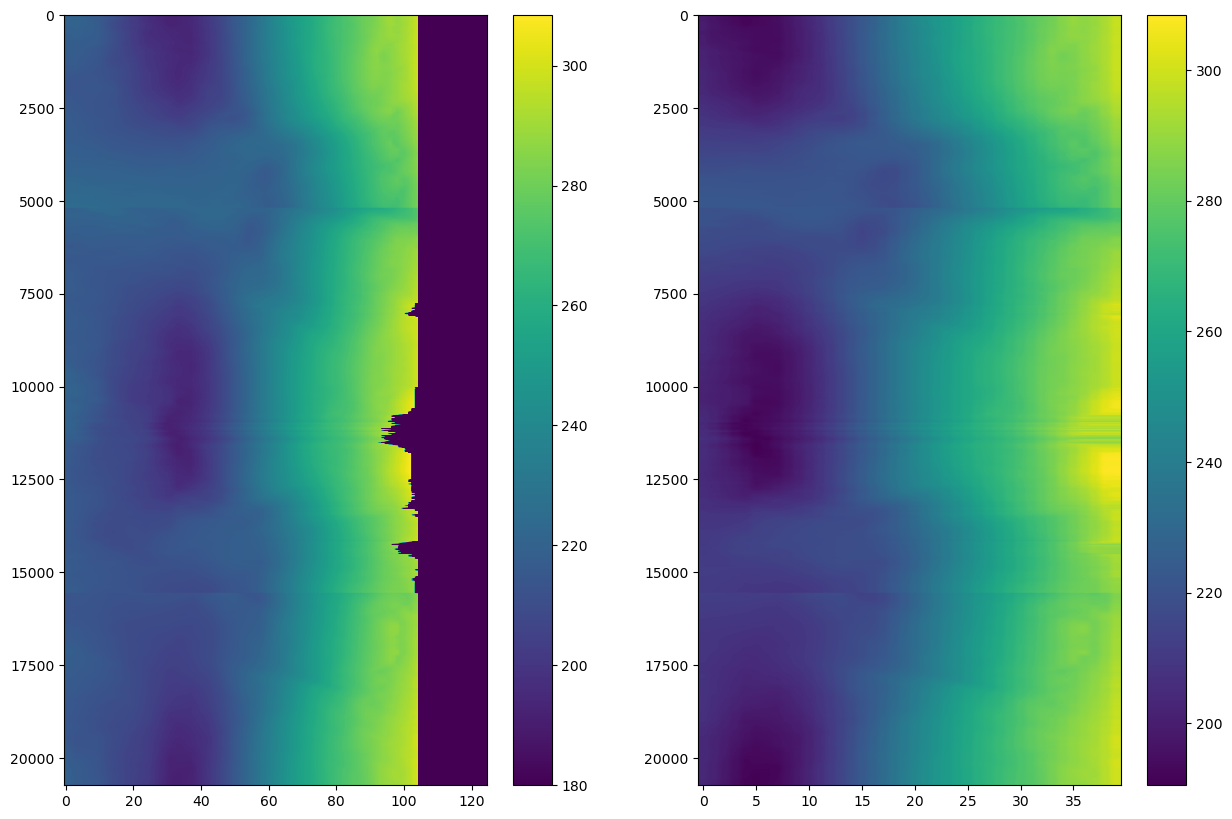

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# im0 = axes[0].imshow(np.log(Temperature), aspect='auto', vmin=5, vmax=6)
# im1 = axes[1].imshow(np.log(Temperature_interp), aspect='auto', vmin=5, vmax=6)
im0 = axes[0].imshow(Temperature, aspect='auto', vmin=180)
im1 = axes[1].imshow(Temperature_grid, aspect='auto')
plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])